### Prerequisite: Setup & Basic Cleaning

Run this block first to prepare the dataframe (`df`) for the visualizations. This standardizes column names, handles timestamps, and creates the essential `TotalAmount` metric.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load dataset (assuming file is in working dir)
df = pd.read_csv('uci_online_retail.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Basic Cleaning
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df = df.dropna(subset=['CustomerID']) # Focus on identifiable customers for analytics

# Separate datasets for Sales vs Returns
df_sales = df[df['Quantity'] > 0].copy()
df_returns = df[df['Quantity'] < 0].copy()

# Set seaborn style
sns.set_theme(style="whitegrid", palette="muted")

---

### 1. Monthly Revenue Trend

**Insight:** Tracks the overall financial health and seasonality of the business. We aggregate daily transactions into monthly buckets to reduce noise and spot high-level trends (like the holiday spikes).

/tmp/ipython-input-2547678609.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_sales.set_index('InvoiceDate').resample('M')['TotalAmount'].sum().reset_index()


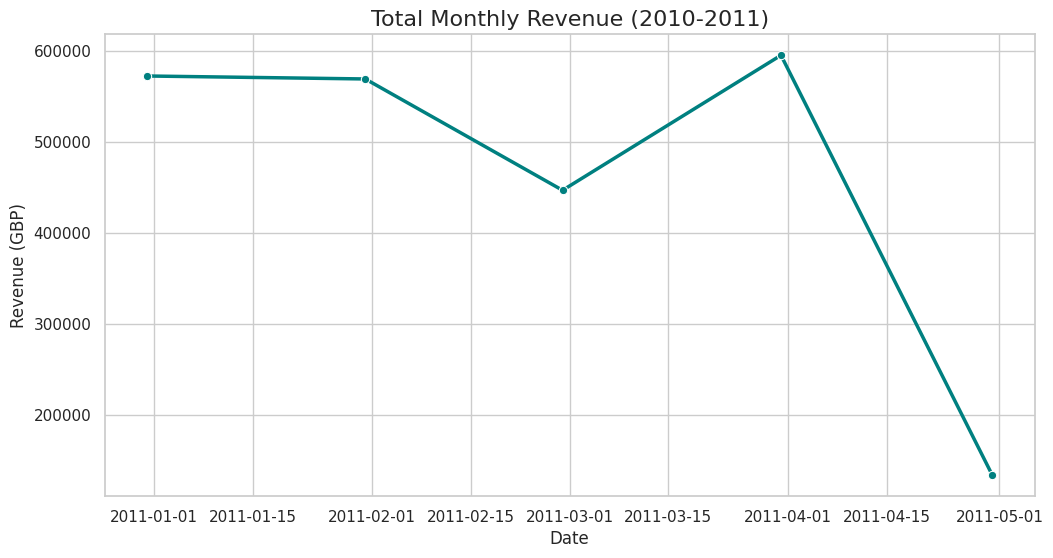

In [ ]:
# Resample to monthly frequency
monthly_sales = df_sales.set_index('InvoiceDate').resample('M')['TotalAmount'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='InvoiceDate', y='TotalAmount', marker='o', linewidth=2.5, color='teal')

plt.title('Total Monthly Revenue (2010-2011)', fontsize=16)
plt.ylabel('Revenue (GBP)')
plt.xlabel('Date')
plt.show()

### 2. Top 10 International Markets (Excluding UK)

**Insight:** Since the UK usually dominates this dataset, it obscures other markets. Excluding the UK reveals which international regions are driving export growth.

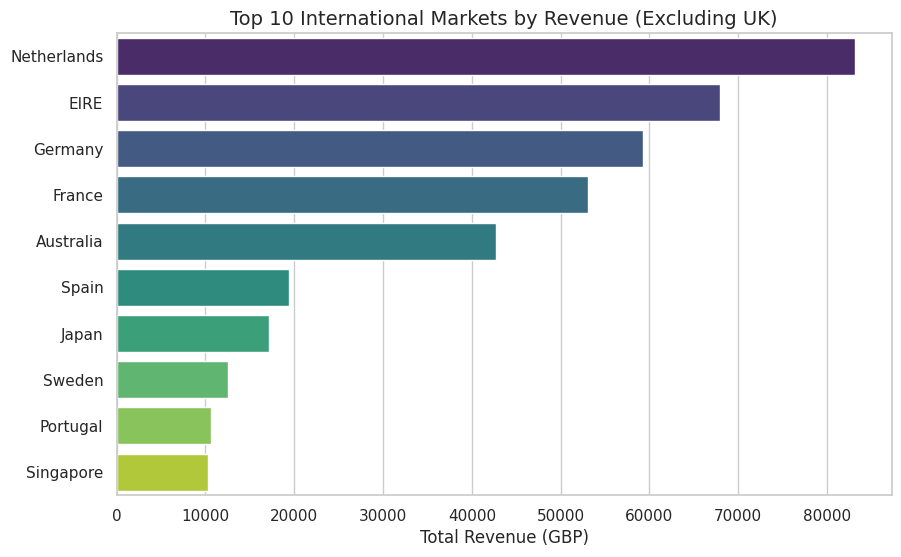

In [ ]:
# Group by Country, sum revenue, and sort
country_sales = df_sales[df_sales['Country'] != 'United Kingdom'].groupby('Country')['TotalAmount'].sum().reset_index()
top_countries = country_sales.sort_values('TotalAmount', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='TotalAmount', y='Country', hue='Country', legend=False, palette='viridis')

plt.title('Top 10 International Markets by Revenue (Excluding UK)', fontsize=14)
plt.xlabel('Total Revenue (GBP)')
plt.ylabel('')
plt.show()

### 3. Heatmap of Peak Shopping Hours

**Insight:** Visualizes the "heat" of sales by Hour of Day vs. Day of Week. This is critical for optimizing customer support staffing or email marketing send times.

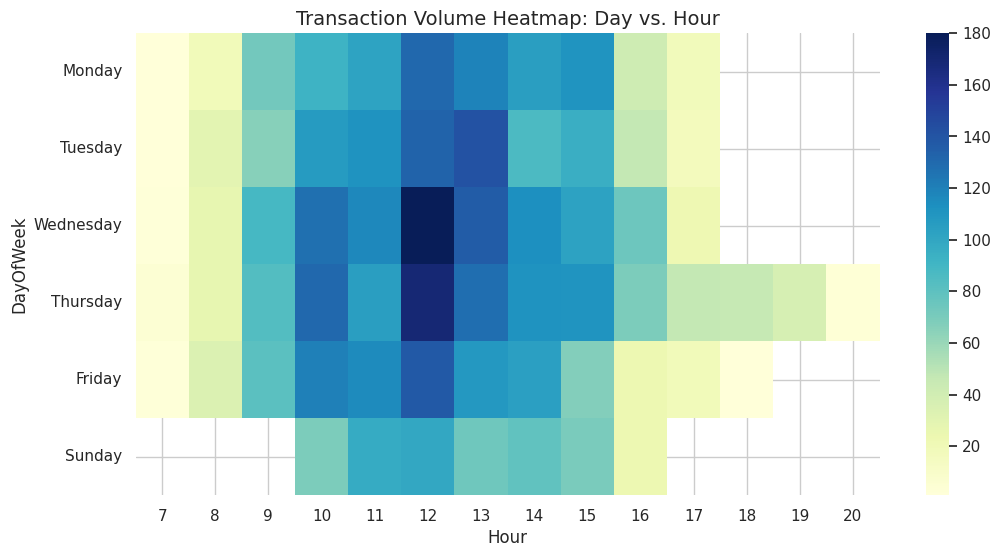

In [ ]:
# Extract time features
df_sales['Hour'] = df_sales['InvoiceDate'].dt.hour
df_sales['DayOfWeek'] = df_sales['InvoiceDate'].dt.day_name()

# Pivot table for heatmap
pivot_table = df_sales.pivot_table(index='DayOfWeek', columns='Hour', values='InvoiceNo', aggfunc='nunique')
# Reorder days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'] # Saturday is usually closed in this specific dataset
pivot_table = pivot_table.reindex(days_order)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=False, fmt=".0f")

plt.title('Transaction Volume Heatmap: Day vs. Hour', fontsize=14)
plt.show()

### 4. Distribution of Transaction Values (Log Scale)

**Insight:** E-commerce data is often highly skewed (many small purchases, few massive wholesalers). Using a log scale helps us see the true shape of the "average" customer basket size.

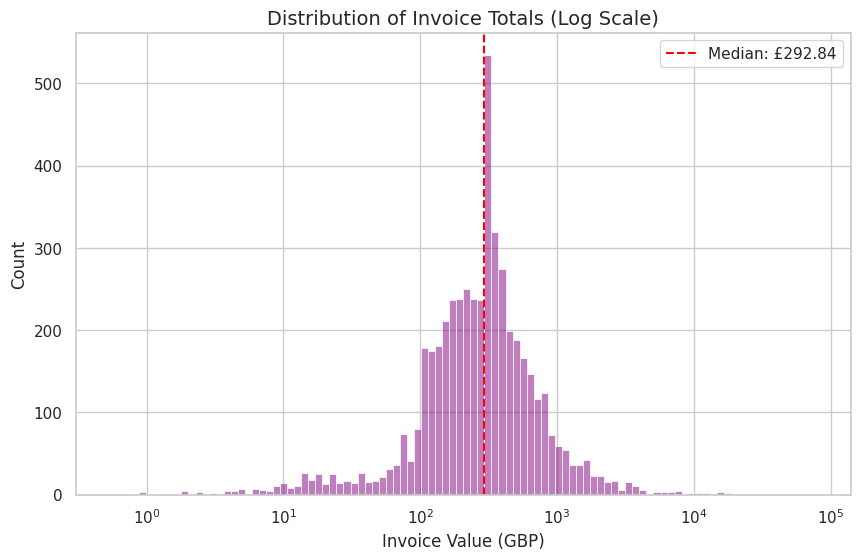

In [ ]:
# Aggregate by Invoice
invoice_totals = df_sales.groupby('InvoiceNo')['TotalAmount'].sum()

plt.figure(figsize=(10, 6))
sns.histplot(invoice_totals, bins=100, log_scale=True, kde=True, color='purple')

plt.title('Distribution of Invoice Totals (Log Scale)', fontsize=14)
plt.xlabel('Invoice Value (GBP)')
plt.axvline(invoice_totals.median(), color='red', linestyle='--', label=f'Median: £{invoice_totals.median():.2f}')
plt.legend()
plt.show()

### 5. Most Popular Products (Top 10)

**Insight:** Identifies volume drivers. Note that high volume doesn't always mean high revenue (cheap items sell more), but these items are crucial for maintaining order velocity.

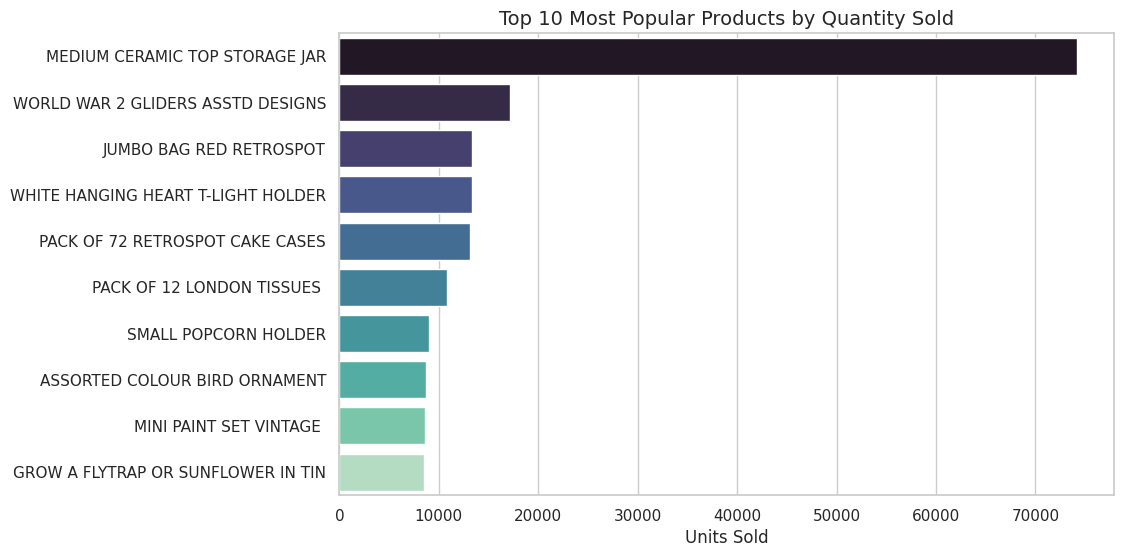

In [ ]:
# Group by Description (Product Name)
top_products = df_sales.groupby('Description')['Quantity'].sum().reset_index().sort_values('Quantity', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_products, x='Quantity', y='Description', hue='Description', legend=False, palette='mako')

plt.title('Top 10 Most Popular Products by Quantity Sold', fontsize=14)
plt.xlabel('Units Sold')
plt.ylabel('')
plt.show()

### 6. Customer Segmentation (RFM: Recency vs. Monetary)

**Insight:** A classic scatterplot to identify "Champions" (Recent & High Spend) vs "At Risk" (Old & High Spend). This is fundamental for targeted marketing campaigns.

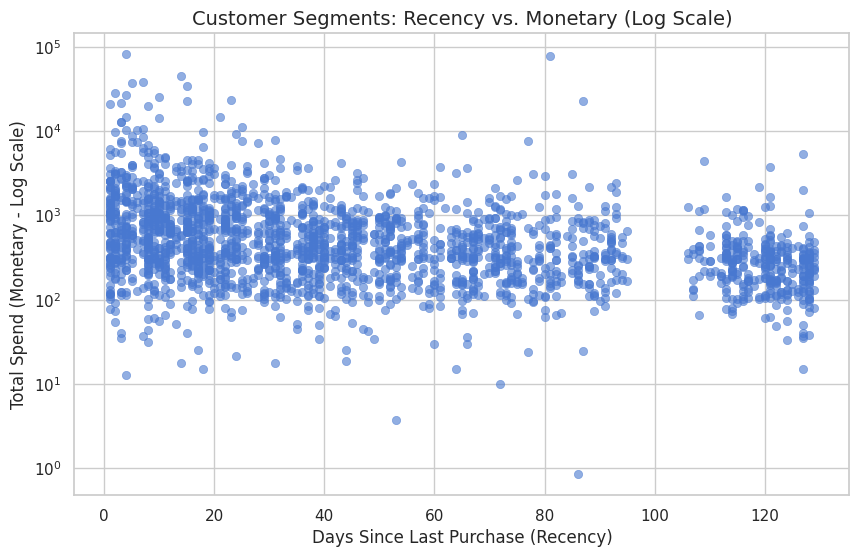

In [ ]:
# Calculate RFM metrics
snapshot_date = df_sales['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df_sales.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'TotalAmount': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'TotalAmount': 'Monetary'})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', alpha=0.6, edgecolor=None)

plt.yscale('log') # Log scale handles the massive wholesalers
plt.title('Customer Segments: Recency vs. Monetary (Log Scale)', fontsize=14)
plt.xlabel('Days Since Last Purchase (Recency)')
plt.ylabel('Total Spend (Monetary - Log Scale)')
plt.show()

### 7. Return Rate by Country

**Insight:** Returns kill profit margins. This plot highlights which countries have the highest percentage of returned items, indicating potential logistics or cultural issues.

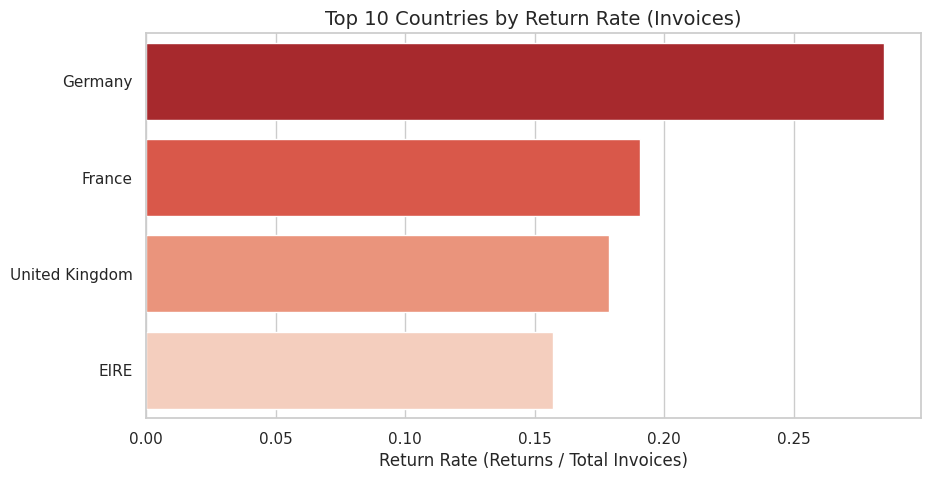

In [ ]:
# Calculate Sales vs Returns count by country
country_stats = df.assign(Type=np.where(df['Quantity']>0, 'Sale', 'Return')) \
                  .groupby(['Country', 'Type'])['InvoiceNo'].nunique().unstack().fillna(0)

# Filter for meaningful sample size (>50 transactions)
country_stats = country_stats[country_stats['Sale'] > 50]
country_stats['ReturnRate'] = country_stats['Return'] / (country_stats['Sale'] + country_stats['Return'])

# Sort and Plot
plot_data = country_stats.sort_values('ReturnRate', ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_data, x='ReturnRate', y='Country', hue='Country', legend=False, palette='Reds_r')

plt.title('Top 10 Countries by Return Rate (Invoices)', fontsize=14)
plt.xlabel('Return Rate (Returns / Total Invoices)')
plt.ylabel('')
plt.show()

### 8. Sales Distribution by Day of Week (Boxplot)

**Insight:** Boxplots show the variance in daily sales. It helps answer: "Are Thursdays just busy on average, or was it one lucky day?" It reveals consistency vs. volatility.

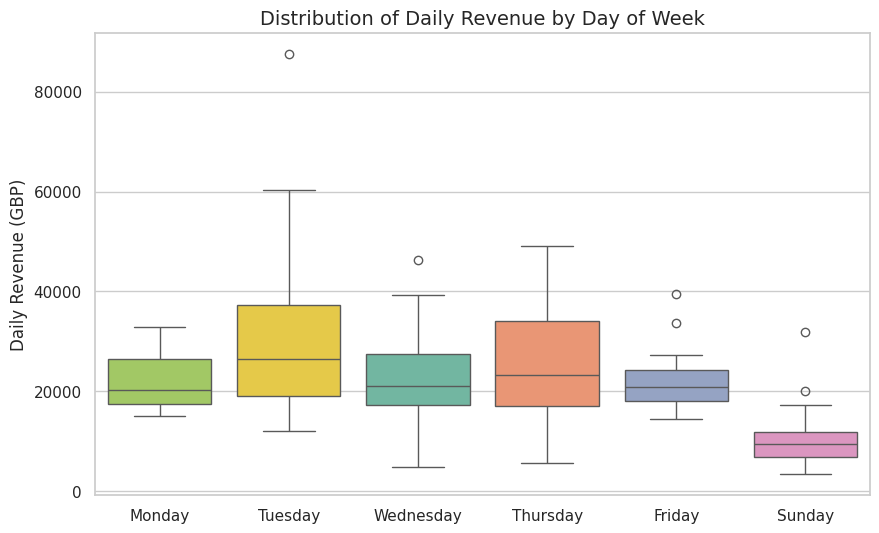

In [ ]:
# Aggregate daily sales
daily_sales = df_sales.groupby(df_sales['InvoiceDate'].dt.date)['TotalAmount'].sum().reset_index()
daily_sales['DayOfWeek'] = pd.to_datetime(daily_sales['InvoiceDate']).dt.day_name()

# Order days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_sales, x='DayOfWeek', y='TotalAmount', order=days_order, hue='DayOfWeek', legend=False, palette='Set2')

plt.title('Distribution of Daily Revenue by Day of Week', fontsize=14)
plt.ylabel('Daily Revenue (GBP)')
plt.xlabel('')
plt.show()

### 9. Price Elasticity Proxy (Unit Price vs. Quantity)

**Insight:** A Jointplot helps visualize the relationship between price and demand. Typically, you expect a curve where cheap items are bought in bulk, and expensive items are bought singly.

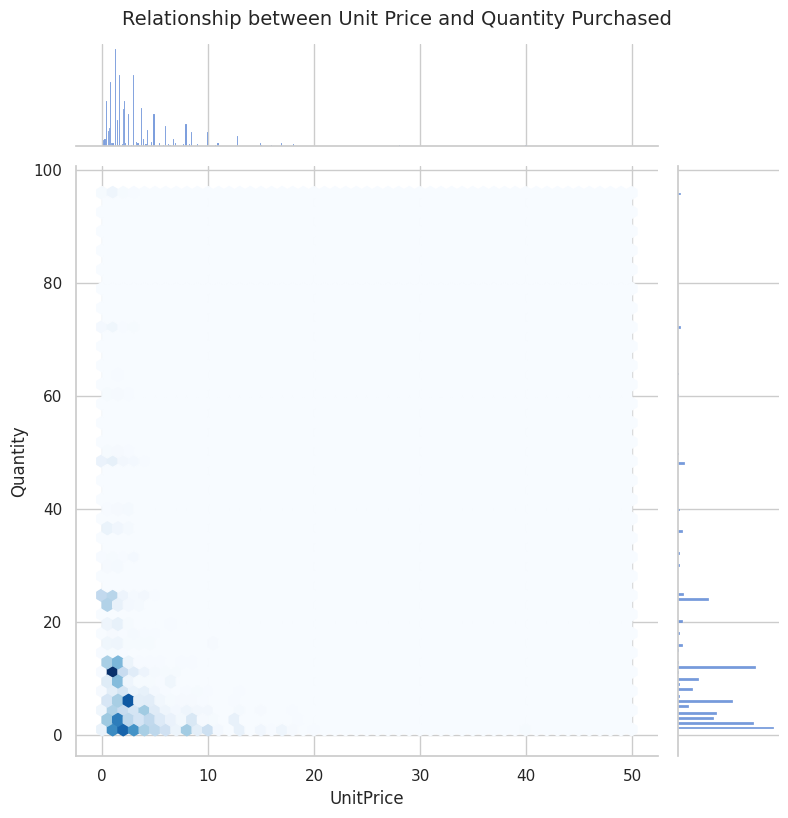

In [ ]:
# Filter outliers for better visualization
filtered_df = df_sales[(df_sales['UnitPrice'] < 50) & (df_sales['Quantity'] < 100)]

g = sns.jointplot(data=filtered_df, x='UnitPrice', y='Quantity', kind='hex', cmap='Blues', height=8)
g.fig.suptitle('Relationship between Unit Price and Quantity Purchased', y=1.02, fontsize=14)
plt.show()

### 10. Pareto Chart (Customer Concentration)

**Insight:** Validates the "80/20 Rule" (80% of revenue often comes from 20% of customers). This line plot shows cumulative revenue; a steep curve indicates high risk (dependency on few whales).

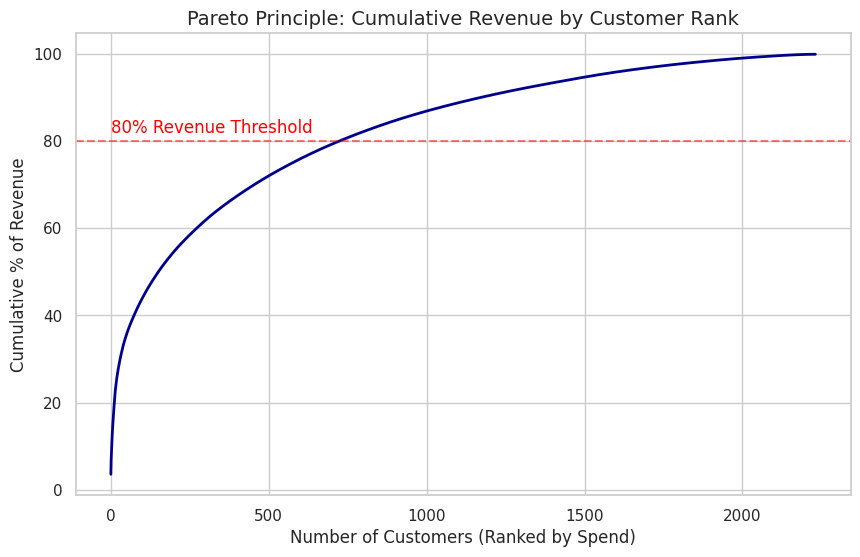

In [ ]:
# Calculate revenue per customer and sort
customer_revenue = df_sales.groupby('CustomerID')['TotalAmount'].sum().sort_values(ascending=False)

# Calculate cumulative percentage
cumulative_revenue = customer_revenue.cumsum() / customer_revenue.sum() * 100
cumulative_revenue = cumulative_revenue.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.lineplot(x=cumulative_revenue.index, y=cumulative_revenue.values, linewidth=2, color='darkblue')

# Visual helper lines
plt.axhline(80, color='red', linestyle='--', alpha=0.5)
plt.text(0, 82, '80% Revenue Threshold', color='red')

plt.title('Pareto Principle: Cumulative Revenue by Customer Rank', fontsize=14)
plt.xlabel('Number of Customers (Ranked by Spend)')
plt.ylabel('Cumulative % of Revenue')
plt.show()

### 11. **Month-over-Month (MoM) Cohort Analysis**.

This is one of the most powerful tools in customer analytics. It answers: *"Of the customers who joined in January, what percentage came back to buy in February, March, etc.?"*

### The Logic

1. **Cohort Month:** The month a customer made their **first** purchase.
2. **Cohort Index:** How many months have passed since that first purchase (Month 1 = First month, Month 2 = Next month, etc.).
3. **Retention Rate:** The percentage of the original group still active in subsequent months.

### Code Snippet: Cohort Analysis & Visualization

This block assumes you have the `df_sales` dataframe from the previous step.

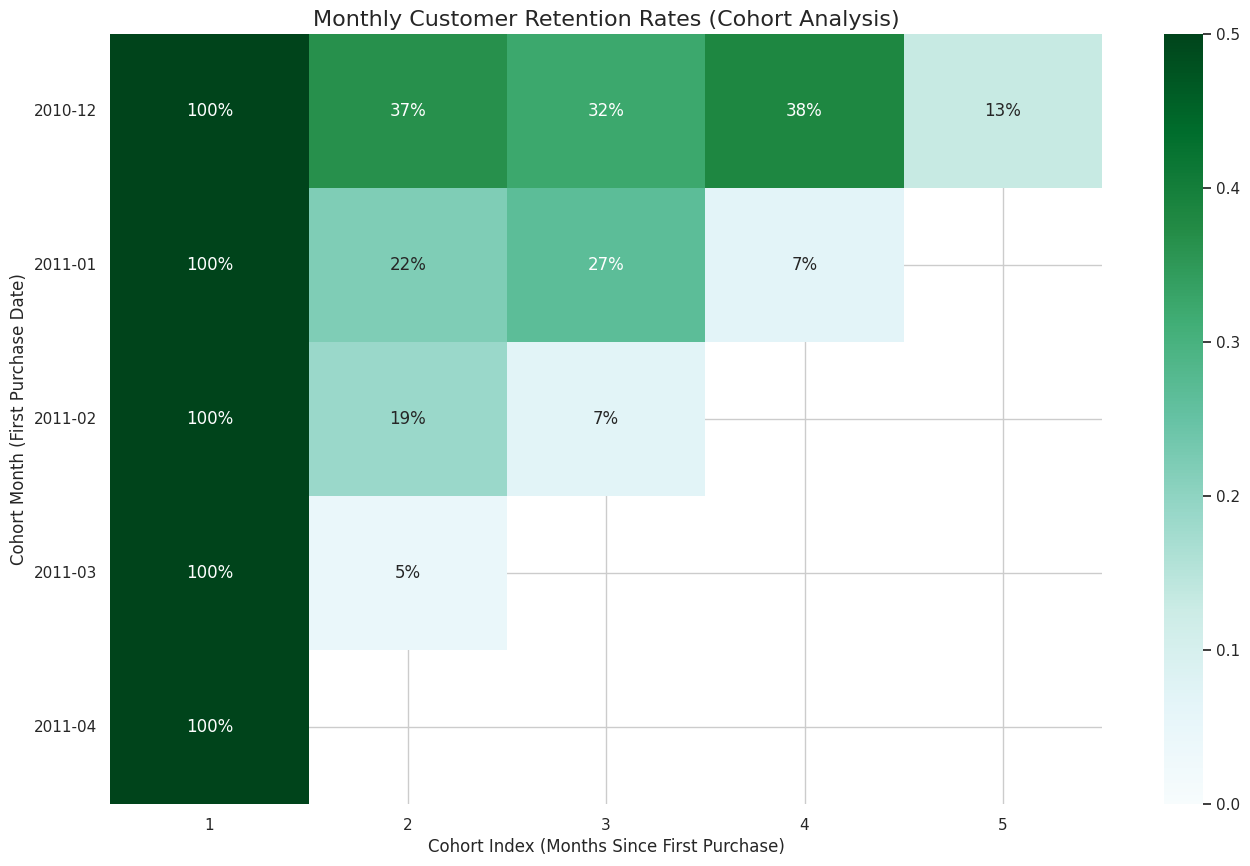

In [ ]:
"""import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt"""
import datetime as dt

# --- Step 1: Data Preparation ---
# Create a function to strip the date down to the first day of the month
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

# Create InvoiceMonth (Transaction Month) column
df_sales['InvoiceMonth'] = df_sales['InvoiceDate'].apply(get_month)

# Group by CustomerID to find the earliest InvoiceMonth (The Cohort Month)
df_sales['CohortMonth'] = df_sales.groupby('CustomerID')['InvoiceMonth'].transform('min')

# --- Step 2: Calculate Cohort Index (Months Passed) ---
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# Extract integer values
invoice_year, invoice_month = get_date_int(df_sales, 'InvoiceMonth')
cohort_year, cohort_month = get_date_int(df_sales, 'CohortMonth')

# Calculate difference in years and months
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# Create Index (1 = First Month, 2 = Second Month, etc.)
df_sales['CohortIndex'] = years_diff * 12 + months_diff + 1

# --- Step 3: Pivot Data for Heatmap ---
# Count unique customers per CohortMonth and CohortIndex
cohort_data = df_sales.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Create Pivot Table
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Calculate Retention as a percentage of the starting size (Month 1)
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# --- Step 4: Visualize with Seaborn ---
plt.figure(figsize=(16, 10))

# Create formatting for y-axis labels (YYYY-MM)
yticklabels = [x.strftime('%Y-%m') for x in retention.index]

# Plot Heatmap
sns.heatmap(data=retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=0.5,
            cmap='BuGn',
            yticklabels=yticklabels)

plt.title('Monthly Customer Retention Rates (Cohort Analysis)', fontsize=16)
plt.ylabel('Cohort Month (First Purchase Date)')
plt.xlabel('Cohort Index (Months Since First Purchase)')
plt.yticks(rotation=0)
plt.show()

### How to Read This Chart

* **Vertical Axis (Y):** These are your "Cohorts." The top row represents customers acquired in the first month of the dataset.
* **Horizontal Axis (X):** The lifetime of the customer in months. Column `1` is 100% (the month they joined).
* **The Cells:** Look at the diagonal or vertical patterns.
* **Good Sign:** If the colors stay dark green as you move right, customers are sticking around.
* **Bad Sign:** If the colors fade to white immediately in column `2`, you have high "one-and-done" churn.
